In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! mkdir ~/../content/data

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gpiosenka/100-bird-species

100% 1.91G/1.91G [00:13<00:00, 206MB/s]
100% 1.91G/1.91G [00:13<00:00, 150MB/s]


In [ ]:
! unzip 100-bird-species.zip -d ~/../content/data

Streaming output truncated to the last 5000 lines.
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/028.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/029.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/030.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/031.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/032.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/033.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/034.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/035.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/036.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/037.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/038.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/039.jpg  
  inflating: /root/../content/data/train/WHITE NECKED RAVEN/040.jpg  
  inflating: /root/../content/data/trai

In [ ]:
# create directories for the three birds
! mkdir /content/data/3-birds
! mkdir /content/data/3-birds/test
! mkdir /content/data/3-birds/train
! mkdir /content/data/3-birds/valid

In [ ]:
# add the data to the created folders
# [('HOUSE FINCH', 258), ('D-ARNAUDS BARBET', 243), ('OVENBIRD', 243)]
! cp -r data/test/HOUSE\ FINCH data/3-birds/test/HOUSE\ FINCH
! cp -r data/test/D-ARNAUDS\ BARBET data/3-birds/test/D-ARNAUDS\ BARBET
! cp -r data/test/OVENBIRD data/3-birds/test/OVENBIRD

! cp -r data/train/HOUSE\ FINCH data/3-birds/train/HOUSE\ FINCH
! cp -r data/train/D-ARNAUDS\ BARBET data/3-birds/train/D-ARNAUDS\ BARBET
! cp -r data/train/OVENBIRD data/3-birds/train/OVENBIRD

! cp -r data/valid/HOUSE\ FINCH data/3-birds/valid/HOUSE\ FINCH
! cp -r data/valid/D-ARNAUDS\ BARBET data/3-birds/valid/D-ARNAUDS\ BARBET
! cp -r data/valid/OVENBIRD data/3-birds/valid/OVENBIRD

In [ ]:
# imports
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
birdcsv = pd.read_csv('/content/data/birds.csv')
print(birdcsv.columns)

bird_count = {}
birds = birdcsv['labels'].copy()
for bird in birds:
  bird_count[bird] = bird_count.get(bird, 0) + 1

total_samples = birdcsv.shape[0]
print("Total samples: ", total_samples)
percent = []
bird_labels = bird_count.keys()

for bird, count in bird_count.items():
  print("Bird:", bird + ",", "Samples:", count)

list_of_counts = list(map(lambda x: (x, bird_count[x]), bird_count.keys()))
print(sorted(list_of_counts, key=lambda x: x[1], reverse=True)[0:3])



Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')
Total samples:  87874
Bird: ABBOTTS BABBLER, Samples: 173
Bird: ABBOTTS BOOBY, Samples: 190
Bird: ABYSSINIAN GROUND HORNBILL, Samples: 189
Bird: AFRICAN CROWNED CRANE, Samples: 145
Bird: AFRICAN EMERALD CUCKOO, Samples: 164
Bird: AFRICAN FIREFINCH, Samples: 147
Bird: AFRICAN OYSTER CATCHER, Samples: 165
Bird: AFRICAN PIED HORNBILL, Samples: 197
Bird: AFRICAN PYGMY GOOSE, Samples: 189
Bird: ALBATROSS, Samples: 142
Bird: ALBERTS TOWHEE, Samples: 171
Bird: ALEXANDRINE PARAKEET, Samples: 175
Bird: ALPINE CHOUGH, Samples: 176
Bird: ALTAMIRA YELLOWTHROAT, Samples: 160
Bird: AMERICAN AVOCET, Samples: 189
Bird: AMERICAN BITTERN, Samples: 180
Bird: AMERICAN COOT, Samples: 168
Bird: AMERICAN FLAMINGO, Samples: 174
Bird: AMERICAN GOLDFINCH, Samples: 143
Bird: AMERICAN KESTREL, Samples: 165
Bird: AMERICAN PIPIT, Samples: 189
Bird: AMERICAN REDSTART, Samples: 149
Bird: AMERICAN ROBIN, Samples: 157
Bird: AMERIC

In [ ]:
#hyperparameters

input_size = 224
hidden_size = 1024 #arbitrary
num_classes = 3
num_epochs = 150 #arbitrary
batch_size = 10 #arbitrary
learning_rate = 0.0003

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = "/content/data/3-birds"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(("../" + data_dir + "/" + x + "/"), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/150], Step [12/72], Loss: 2.7973
Epoch [1/150], Step [24/72], Loss: 1.7585
Epoch [1/150], Step [36/72], Loss: 1.0900
Epoch [1/150], Step [48/72], Loss: 1.4058
Epoch [1/150], Step [60/72], Loss: 1.0473
Epoch [1/150], Step [72/72], Loss: 0.6360
Test Accuracy of the model_conv on the 15 test images: 33.333333333333336 %
Test Accuracy of the model_conv on the train images: 33.05322128851541 %
Epoch [2/150], Step [12/72], Loss: 1.0976
Epoch [2/150], Step [24/72], Loss: 1.0801
Epoch [2/150], Step [36/72], Loss: 1.0054
Epoch [2/150], Step [48/72], Loss: 1.0572
Epoch [2/150], Step [60/72], Loss: 1.0921
Epoch [2/150], Step [72/72], Loss: 1.1960
Test Accuracy of the model_conv on the 15 test images: 33.333333333333336 %
Test Accuracy of the model_conv on the train images: 36.27450980392157 %
Epoch [3/150], Step [12/72], Loss: 1.0969
Epoch [3/150], Step [24/72], Loss: 1.1828
Epoch [3/150], Step [36/72], Loss: 1.0578
Epoch [3/150], Step [48/72], Loss: 1.1053
Epoch [3/150], Step [60/72], L

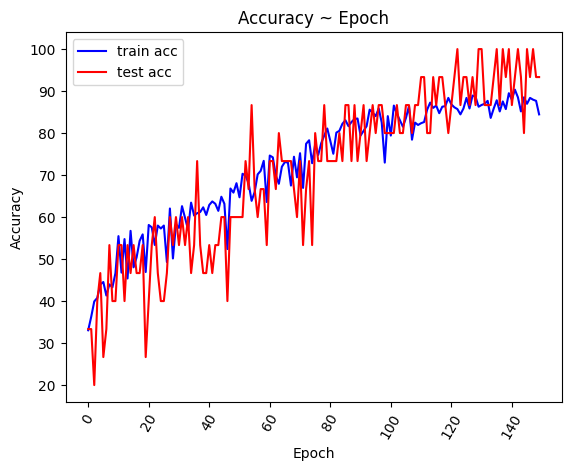

In [ ]:
# convolutional network class

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(64,32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(15*15*32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out1 = self.layer2(out)
        out = self.layer3(out1)
        out += out1
        out = self.layer4(out)
        out1 = self.layer5(out)
        out = self.layer6(out1)
        out += out1
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model_conv = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)

# Train the model_conv
train_loader = dataloaders_dict['train']
test_loader = dataloaders_dict['valid']
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_conv(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 12 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model_conv
    model_conv.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_conv(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model_conv on the 15 test images: {} %'.format(100 * correct / total))
        test_acc_list.append(100 * correct / total)

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_conv(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model_conv on the train images: {} %'.format(100 * correct / total))
        train_acc_list.append(100 * correct / total)



plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
